# FIT5196 Task 4 in Assessment 2
#### Student Name: Chuangfu Xie
#### Student ID: 27771539

Date: 13/05/2018

Version: 1.0

Environment: Python 3.6.4
Packages list:
1. Pandas 0.22.0  
2. numpy 1.14.0
4. sklearn 0.19.1

In [1]:
import sys
print (sys.version)

3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 12:04:33) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


## 1.  Import libraries 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor

## 2. Inspection

In [3]:
df = pd.read_csv('./dataset4_with_outliers.csv')
# have a peek at the dataset
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
0,5437400630,20141016T000000,625000.0,4,2.25,1920,8259,2.0,0,0,4,8,1920,0,1979,0,98027,47.5616,-122.088
1,3999300290,20141016T000000,850000.0,3,3.50,2620,11148,2.0,0,4,4,9,2060,560,1977,0,98008,47.5845,-122.115
2,2525059134,20141016T000000,500000.0,2,1.50,1760,12000,1.0,0,0,4,7,1760,0,1964,0,98052,47.6288,-122.109
3,1862400285,20141016T000000,375000.0,3,1.00,1200,5404,1.0,0,0,3,6,1200,0,1937,0,98117,47.6969,-122.368
4,7199320190,20141016T000000,618000.0,4,2.25,2470,7350,1.0,0,0,3,7,1600,870,1978,0,98052,47.6936,-122.128


### 2.1 Feature Selection

First, we use `check_all_corr()` function to sift those columns which correlation coefficient are under the theshold, and then return the columns need to drop and all potentially related columns:

In [4]:
def check_all_corr(df, theshold=0.5):
    col_list=df.corr().columns.tolist()
    pairs_dict=dict()
    for c in col_list:
        for r in col_list:
            corr_value = df.corr().loc[r,c]
            if corr_value > theshold and corr_value!=1:
                if c not in pairs_dict:
                    pairs_dict[c]=dict()
                else:
                    pairs_dict[c][r] = corr_value #save pair
    # remove columns which pass the theshold
    drop_list = df.columns.tolist()
    for c in pairs_dict:
        for r in pairs_dict[c]:
            if r in drop_list:
                drop_list.remove(r)
        if c in pairs_dict:
            try:
                drop_list.remove(c)
            except:
                pass
    return drop_list, pairs_dict

In [5]:
drop_list, corr_results = check_all_corr(df)
print(drop_list)

['id', 'date', 'sqft_lot', 'waterfront', 'view', 'condition', 'sqft_basement', 'yr_renovated', 'zipcode', 'lat', 'long']


Now we have all candidate columns are potentially having no relationship with other columns. However, we can not just simply drop all of them. Let's have a closed look at these columns.  
Accroding to instructions, we can find that:
1. Data in <font color='blue'>**id**</font> are just identifier, we can drop this.
2. Each record can have different value in <font color='blue'>**date**</font>, we can drop this.
3. <font color='blue'>**zipcode**</font>, <font color='blue'>**lat**</font> and <font color='blue'>**lon**</font> are used to locate the building, we can drop this.
4. <font color='blue'>**waterfront**</font> are just feature of the building, but may having relationship with <font color='blue'>**view**</font>, though the value of the view takes might be subjective to some extent. we keep this.
5. From task 3 we knows <font color='blue'>**sqft_basement**</font>, <font color='blue'>**sqft_living**</font> and <font color='blue'>**sqft_above**</font> obey to a formula. However, <font color='blue'>**sqft_lot**</font> can be outlier. So, we keep <font color='blue'>**sqft_lot**</font>.
6. <font color='blue'>**yr_renovated**</font> are just history, where a renovation happens, the value will be non-zero. On the other hand, <font color='blue'>**condition**</font> may propriately describe at what degree the building is maintained. Thus, we just keep the <font color='blue'>**condition**</font>.

In [6]:
drop_list = ['id', 'date', 'sqft_basement', 'yr_renovated', 'zipcode', 'lat', 'long']
df_corr = df.drop(columns=drop_list)
df_corr.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built
count,9.996000e+03,9996.000000,9996.000000,9996.000000,9.996000e+03,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000
mean,4.980468e+05,3.356943,2.082558,2025.039916,1.547281e+04,1.487345,0.002401,0.194678,3.374250,7.593037,1750.824930,1972.056423
std,2.540477e+05,0.937060,0.736420,854.963922,4.297506e+04,0.540751,0.048943,0.679519,0.623769,1.112505,793.994317,28.847071
min,8.995000e+04,1.000000,0.500000,390.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,4.000000,390.000000,1900.000000
25%,3.200000e+05,3.000000,1.500000,1400.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1180.000000,1953.000000
50%,4.400000e+05,3.000000,2.250000,1870.000000,7.509500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1530.000000,1976.000000
75%,6.100000e+05,4.000000,2.500000,2480.000000,1.036150e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2160.000000,1998.000000
max,2.700000e+06,20.000000,6.500000,7880.000000,1.164794e+06,3.500000,1.000000,4.000000,5.000000,13.000000,7880.000000,2015.000000


### 2.2 Columns contains the most number of outliers

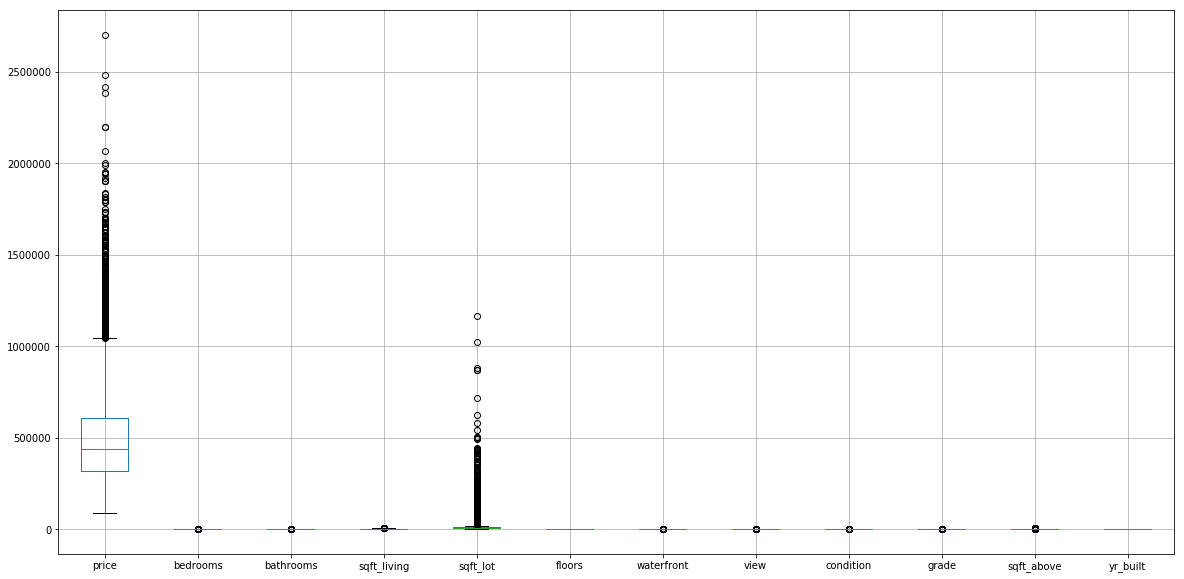

In [7]:
ax, lines = df_corr.boxplot(figsize=(20,10), return_type='both')
all_outliers = dict()
for col, each in zip(df_corr.columns.tolist(), lines['fliers']):
    # collect all outliers
    all_outliers[col] = each.get_ydata().tolist()

In [8]:
n_outliers = dict()
for col in all_outliers:
    n_outliers[col] = len(all_outliers[col])
n_outliers

{'bathrooms': 80,
 'bedrooms': 218,
 'condition': 11,
 'floors': 0,
 'grade': 740,
 'price': 371,
 'sqft_above': 267,
 'sqft_living': 223,
 'sqft_lot': 1111,
 'view': 864,
 'waterfront': 24,
 'yr_built': 0}

Now we can find that the column which contains the most significant number of outliers is <font color='blue'>**sqft_lot**</font>: 1111 potential outliers.

### 2.3 LOF –– Local Outlier Factor

As there are 12 columns to consider, we can not simply identify outliers by Boxplot. Since we know all the correlation coefficient of these columns, however, outlier should be identify by the pattern which most records are grouping in a cluster-like. To this extent, we employ LOF technique.

As LOF share some fundamental concepts with density-based clustering approaches, by reeferencing to sklearn documentation:
> "... the anomaly score depends on **how isolated the object is with respect to the surrounding neighborhood**. More precisely, **locality is given by k-nearest neighbors**, whose distance is used to **estimate the local density**. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially **lower density than their neighbors**, These are considered **outliers**."

First, we need to find the **k**, as we can't visualise the clustering in the dataset, we can use a simple method to estimate k:

In [9]:
k = np.sqrt(len(df.index))
print(k)

99.9799979995999


As k is usually odd, let's assume that k is 100. Since the most number of potential outliers are occurs in <font color='blue'>**sqft_lot**</font> , we use it to calculate the contamination ratio, i.e the proportion of outliers in the data set:

In [10]:
model = LocalOutlierFactor(100, p=13, contamination=1111/len(df.index))
df_corr['outliers'] = model.fit_predict(df_corr)

Now we have all the outliers predicted by LOF model. let's check on these outlier with price per square footage:

In [11]:
df_outlier = df_corr[df_corr.outliers == -1]
df_outlier = np.round(df_outlier.price/df_outlier.sqft_lot)
df_outlier.describe()

count    1111.000000
mean       18.345635
std        37.200374
min         0.000000
25%         7.000000
50%        13.000000
75%        20.000000
max       716.000000
dtype: float64

In [12]:
df_no = df_corr[df_corr.outliers == 1]
df_no = np.round(df_no.price/df_no.sqft_lot)
df_no.describe()

count    8885.000000
mean       95.106021
std        94.449464
min         1.000000
25%        40.000000
50%        64.000000
75%       110.000000
max      1346.000000
dtype: float64

Here we can find data distribution with data in outliers against others:
1. Data in outliers: mean: 18.25; median: 13.00; std:37.2
2. Data without outliers: mean: 95.10; median: 64; std: 94.45

It seems that data in outliers are having extreme low price with mean of 18.25! Let's check in another way:

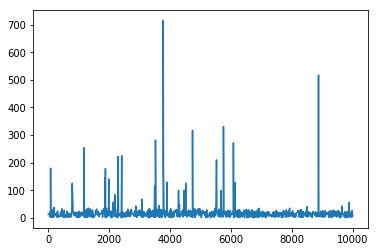

In [13]:
df_outlier.plot()

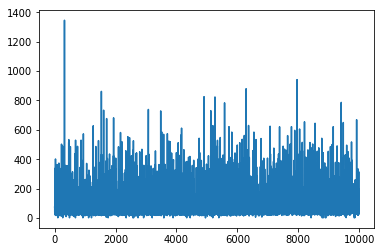

In [14]:
df_no.plot()

It seems that most of the outliers has been identified.  
Then we can remove these outliers:

In [15]:
df = df[df_corr['outliers']==1]

## 3. Export CSV 

In [16]:
df.to_csv('./dataset4_solution.csv',index=False)

### Reference

* Thirumuruganathan S. (May 17, 2010). *A Detailed Introduction to K-Nearest Neighbor (KNN) Algorithm* Retrieve from:[https://saravananthirumuruganathan.wordpress.com/2010/05/17/a-detailed-introduction-to-k-nearest-neighbor-knn-algorithm/](https://saravananthirumuruganathan.wordpress.com/2010/05/17/a-detailed-introduction-to-k-nearest-neighbor-knn-algorithm/)